In [113]:
# Preprocessing & results----------------
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder, normalize
from sklearn.feature_selection import chi2
# nlp preprocessing
import spacy
# Models-------------------------
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
import sklearn.gaussian_process.kernels as kls
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
# for visualizing ---------------
import pydotplus
from sklearn import tree
from sklearn.externals.six import StringIO 
from IPython.display import Image, display
import seaborn as sns
import matplotlib.pyplot as plt
# General purpose
import re
import pandas as pd
import pickle
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("reproducible_dataset_iclr2017.csv")
data.head(3)

,id,n_authors,len_char_title,len_word_title,len_char_abstract,len_word_abstract,n_keywords,ref_len,ref_latest,contains_ml_keyword,...,num_sections,contains_appendix,fig_tab_eqn_count,contains_table,contains_figure,contains_equation,iclr_references,label,max_pub,max_cit
0,HyenWc5gx,3,87,11,1464,219,3,40,2016,1,...,20,1,8,1,0,1,0,Reject,83,1908
1,Hk8TGSKlg,2,74,9,769,109,2,17,2016,1,...,16,1,2,1,1,1,0,Accept,113,3062
2,HkIQH7qel,4,73,8,1007,155,1,21,2016,1,...,15,0,9,1,1,1,2,Reject,47,2464


In [3]:
print(data.columns, len(data.columns))

Index(['id', 'n_authors', 'len_char_title', 'len_word_title',
       'len_char_abstract', 'len_word_abstract', 'n_keywords', 'ref_len',
       'ref_latest', 'contains_ml_keyword', 'avg_sent_len', 'abs_glove_avg',
       'contains_sota', 'num_recent_refs', 'avg_ref_length', 'num_sections',
       'contains_appendix', 'fig_tab_eqn_count', 'contains_table',
       'contains_figure', 'contains_equation', 'iclr_references', 'label',
       'max_pub', 'max_cit'],
      dtype='object') 25


## Augment the GS information

In [4]:
with open("features/GS_MMM_cit_pub_count_2017.pickle", "rb") as f:
    gs_mmm = pickle.load(f)

In [5]:
gs_mmm["HyenWc5gx"]

{'authors': ['Matthew Riemer', 'Elham Khabiri', 'Richard Goodwin'],
 'cit_count_gs': [9, 199, 816],
 'gs_cit_stat': [341.3333333333333, 816, 9, 199.0],
 'gs_pub_stat': [24.0, 42, 7, 23.0],
 'hindex': [9.0, 7.5, 24.0],
 'id': 'HyenWc5gx',
 'label': 'Reject',
 'pub_count_gs': [7, 23, 42],
 'title': 'Representation Stability as a Regularizer for Improved Text Analytics Transfer Learning'}

In [6]:
def gs_pub_func(row):
    pid = row["id"]
    if "gs_pub_stat" in gs_mmm[pid]:
        return pd.Series([gs_mmm[pid]["gs_pub_stat"][0], gs_mmm[pid]["gs_pub_stat"][1], gs_mmm[pid]["gs_pub_stat"][2], gs_mmm[pid]["gs_cit_stat"][3]])
    else:
        return pd.Series([0,0,0,0])

In [7]:
data[['gs_pub_mean', 'gs_pub_max', 'gs_pub_min', 'gs_pub_med']] = data.apply(gs_pub_func, axis="columns")

In [8]:
def gs_cit_func(row):
    pid = row["id"]
    if "gs_cit_stat" in gs_mmm[pid]:
        return pd.Series([gs_mmm[pid]["gs_cit_stat"][0], gs_mmm[pid]["gs_cit_stat"][1], gs_mmm[pid]["gs_cit_stat"][2], gs_mmm[pid]["gs_cit_stat"][3]])
    else:
        return pd.Series([0,0,0,0])

In [9]:
data[['gs_cit_mean', 'gs_cit_max', 'gs_cit_min', 'gs_cit_med']] = data.apply(gs_cit_func, axis="columns")

In [11]:
print(data.columns, len(data.columns))
data.head(2)

Index(['id', 'n_authors', 'len_char_title', 'len_word_title',
       'len_char_abstract', 'len_word_abstract', 'n_keywords', 'ref_len',
       'ref_latest', 'contains_ml_keyword', 'avg_sent_len', 'abs_glove_avg',
       'contains_sota', 'num_recent_refs', 'avg_ref_length', 'num_sections',
       'contains_appendix', 'fig_tab_eqn_count', 'contains_table',
       'contains_figure', 'contains_equation', 'iclr_references', 'label',
       'max_pub', 'max_cit', 'gs_pub_mean', 'gs_pub_max', 'gs_pub_min',
       'gs_pub_med', 'gs_cit_mean', 'gs_cit_max', 'gs_cit_min', 'gs_cit_med'],
      dtype='object') 33


,id,n_authors,len_char_title,len_word_title,len_char_abstract,len_word_abstract,n_keywords,ref_len,ref_latest,contains_ml_keyword,...,max_pub,max_cit,gs_pub_mean,gs_pub_max,gs_pub_min,gs_pub_med,gs_cit_mean,gs_cit_max,gs_cit_min,gs_cit_med
0,HyenWc5gx,3,87,11,1464,219,3,40,2016,1,...,83,1908,24.0,42.0,7.0,199.0,341.333333,816.0,9.0,199.0
1,Hk8TGSKlg,2,74,9,769,109,2,17,2016,1,...,113,3062,96.5,172.0,21.0,2371.5,2371.500000,4597.0,146.0,2371.5


In [14]:
# To plot the Decision Tree--------------------------------------------
def plot(clf):
    dot_data = StringIO()
    tree.export_graphviz(clf[0], 
    out_file=dot_data, 
    class_names=['Accept','Reject'], # the target names.
    feature_names=X.columns, # the feature names.
    filled=True, # Whether to fill in the boxes with colours.
    rounded=True, # Whether to round the corners of the boxes.
    special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
    return Image(graph.create_png())

In [24]:
clf_dict = {'DecisionTree':DecisionTreeClassifier(max_depth=5),
            'RandomForest':RandomForestClassifier(max_depth=10),
            'LogisticR':LogisticRegression(max_iter=10000),
            'LogisticLassoR':LogisticRegression(max_iter=10000, penalty='l1',solver='liblinear'),
            'RidgeClf':RidgeClassifier(max_iter=10000),
            'SVC':SVC(kernel='rbf'),
            'GaussNB':GaussianNB(),
            'NeuralNet':MLPClassifier((500),activation='logistic'),
            'KNN':KNeighborsClassifier(n_neighbors=5),
            'GaussianProcessClf':GaussianProcessClassifier(kernel=kls.RBF())
            }

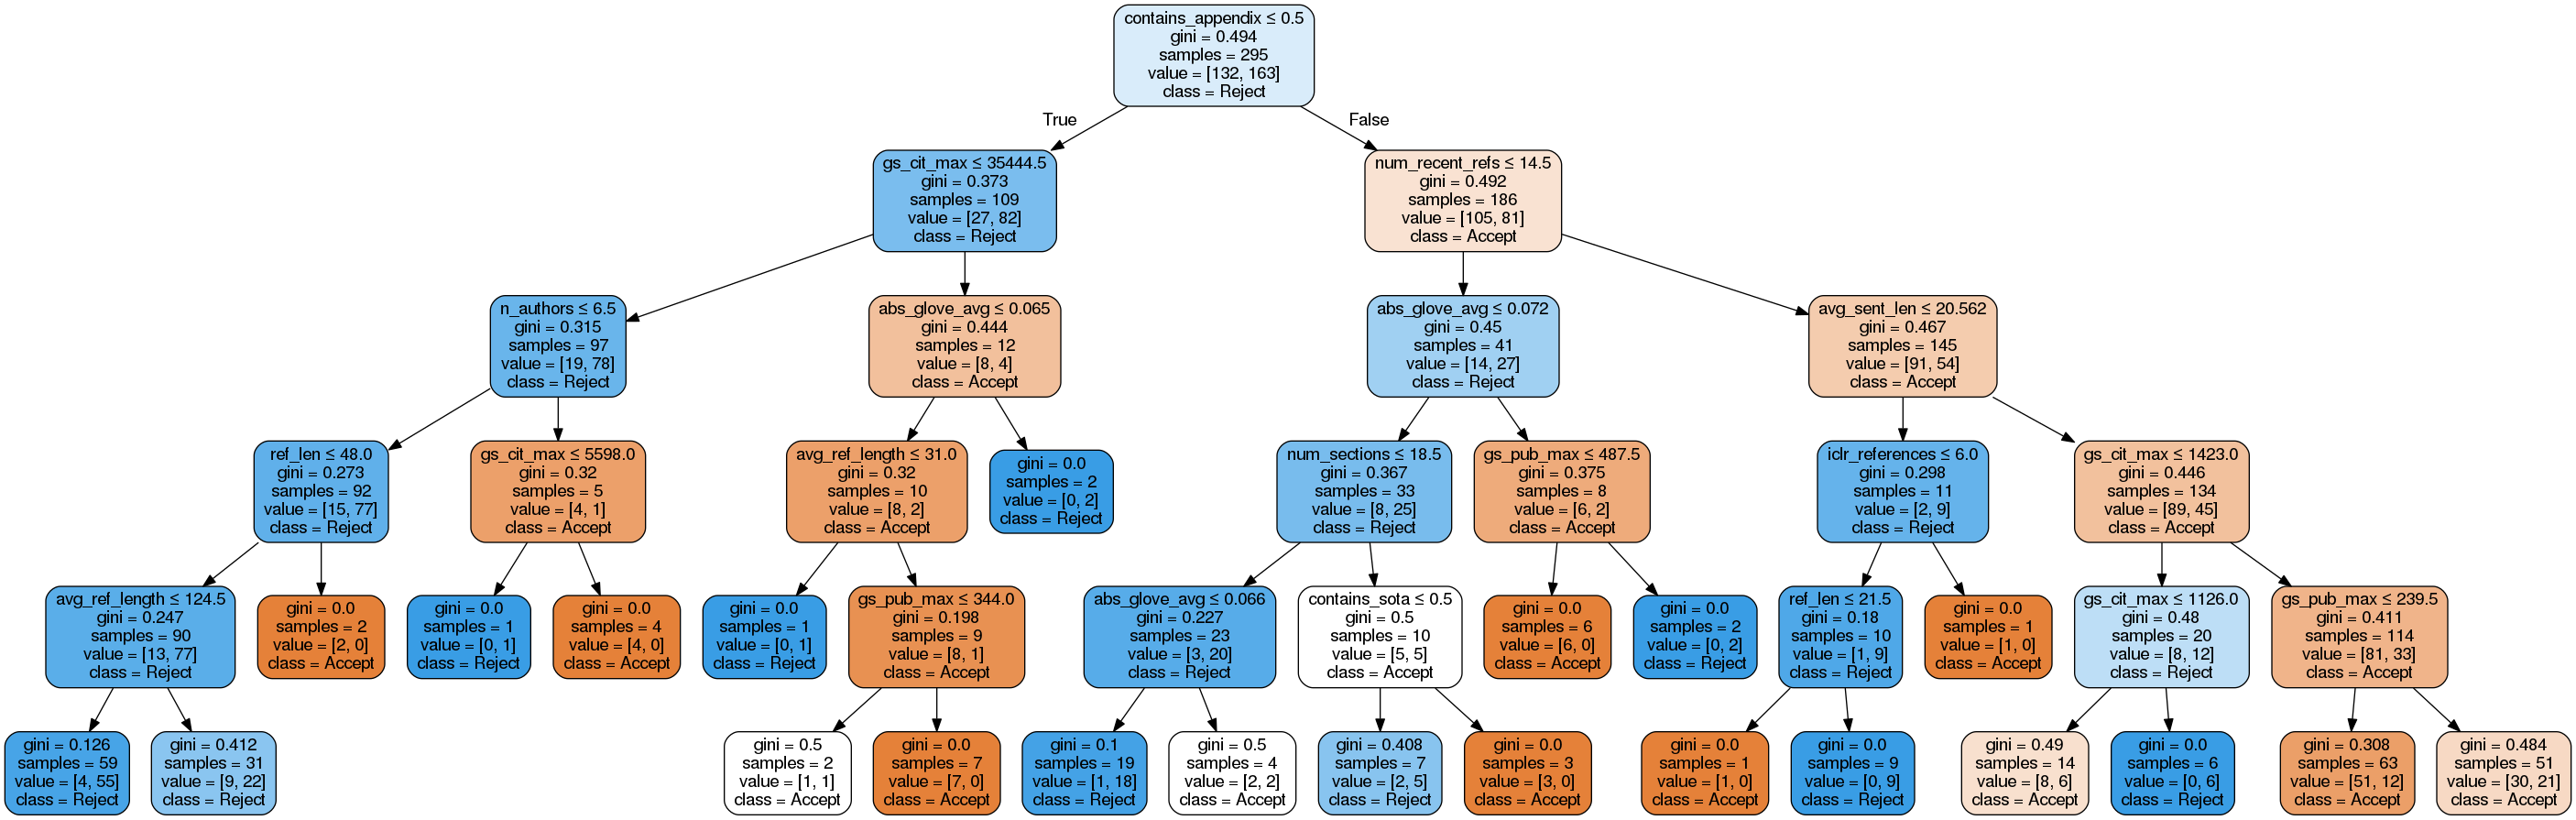

In [30]:
model_results = pd.DataFrame()
model_results['Accuracy'] = None
model_results['CVresults'] = None

for clf_name,clf in clf_dict.items():
#   X = data.drop(columns=['id','label'])
    X = data.drop(columns=['id','label', 'len_char_title', 'len_word_title','len_char_abstract', 
                           'len_word_abstract', 'max_pub', 'max_cit', 'gs_cit_mean', 'gs_cit_min', 
                           'gs_cit_med', 'gs_pub_mean', 'gs_pub_min', 'gs_pub_med'])
    X_normalized = normalize(X)
    y = data['label']
    results = cross_validate(clf, X, y, return_estimator=True)
    clf = results['estimator']
    results.pop('estimator')
    accuracy = np.mean(results['test_score'])
    model_results.loc[clf_name, ['Accuracy', 'CVresults']] = [accuracy, results]
    if clf_name == 'DecisionTree':
        display(plot(clf))

# CHI2 test

In [115]:
X = data.drop(columns=['id','label'])
X_normalized = normalize(X)
y = data['label']

chi_stat = chi2(X, y)

In [117]:
chi2_df = pd.DataFrame()

for feat, (chi2_val, pval) in zip(X.columns, chi_stat):
    chi2_df["feature", "chi2", "p_val"] = [feat, chi2_val, pval]

ValueError: too many values to unpack (expected 2)

In [126]:
sig_df = pd.DataFrame(columns=('feature', 'chi2_val', 'p_val'))
sig_df["feature"] = X.columns
sig_df["chi2_val"] = chi_stat[0][:]
sig_df["p_val"] = chi_stat[1][:]

# for a, b in enumerate(X.columns):
#     print(b, chi_stat[0][a], chi_stat[1][a])
#     break

In [127]:
sig_df

,feature,chi2_val,p_val
0,n_authors,8.043973,4.565529e-03
1,len_char_title,41.478411,1.191798e-10
2,len_word_title,9.764679,1.778965e-03
3,len_char_abstract,2.657752,1.030462e-01
4,len_word_abstract,0.024173,8.764463e-01
5,n_keywords,0.804599,3.697219e-01
6,ref_len,74.593901,5.782157e-18
7,ref_latest,0.004709,9.452898e-01
8,contains_ml_keyword,1.239087,2.656470e-01
9,avg_sent_len,4.866744,2.737911e-02


## 1. L2 with less features

In [107]:
X = data.drop(columns=['id','label', 'len_char_title', 'len_word_title','len_char_abstract', 
                           'len_word_abstract', 'max_pub', 'max_cit', 'gs_cit_mean', 'gs_cit_min', 
                           'gs_cit_med', 'gs_pub_mean', 'gs_pub_min', 'gs_pub_med', "iclr_references"])
X_normalized = normalize(X)
y = data['label']
clf = LogisticRegression().fit(X, y)
predictions = clf.predict(X)

results = cross_validate(clf, X, y, return_estimator=True)
results['estimator']
results.pop('estimator')
accuracy = np.mean(results['test_score'])
model_results = [accuracy, results]
# for idx, (prediction, label) in enumerate(zip(predictions, y)):
#     if prediction != label:
#         print(data.loc[idx,:], prediction, label)

In [108]:
model_results

[0.6502114359257217,
 {'fit_time': array([0.00473094, 0.0040617 , 0.00534153]),
  'score_time': array([0.00107884, 0.00105715, 0.00133348]),
  'test_score': array([0.61486486, 0.64189189, 0.69387755])}]

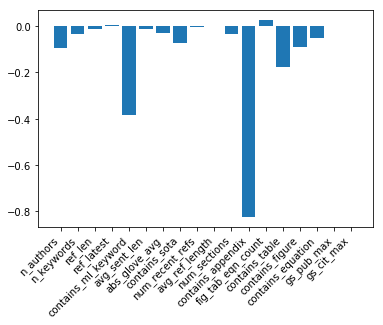

In [109]:
# dir(clf)
# plt.setp(xtickNames, rotation=45, fontsize=8)

xax_labels = X.columns
xax = range(1, len(xax_labels)+1, 1)
yax = np.reshape(clf.coef_, (18,))

plt.bar(xax_labels, yax)
plt.xticks(rotation=45, ha="right")
# plt.xlabel(xax_labels)
plt.show()

In [110]:
print("Id\t Pred \t True")
count = 0

for idx, (prediction, label) in enumerate(zip(predictions, y)):
    if prediction != label:
        print(data.loc[idx,:].id, prediction, label)
        count += 1
print(count, len(y))

Id	 Pred 	 True
HyenWc5gx Accept Reject
Hk8TGSKlg Reject Accept
SkBsEQYll Accept Reject
Skn9Shcxe Reject Accept
ByOvsIqeg Reject Accept
BkjLkSqxg Accept Reject
r17RD2oxe Accept Reject
BJbD_Pqlg Accept Reject
S1dIzvclg Reject Accept
HyAddcLge Accept Reject
r1VGvBcxl Reject Accept
ryxB0Rtxx Reject Accept
Hkg4TI9xl Reject Accept
rJ0-tY5xe Reject Accept
B1hdzd5lg Reject Accept
r1kQkVFgl Accept Reject
H178hw9ex Accept Reject
r1te3Fqel Accept Reject
rJxDkvqee Reject Accept
rJiNwv9gg Reject Accept
SJTQLdqlg Reject Accept
Hk4_qw5xe Reject Accept
BJ_MGwqlg Accept Reject
rkFBJv9gg Reject Accept
r1X3g2_xl Reject Accept
BkVsEMYel Reject Accept
SkYbF1slg Reject Accept
ByvJuTigl Accept Reject
HkYhZDqxg Reject Accept
ByC7ww9le Accept Reject
Syfkm6cgx Accept Reject
B1akgy9xx Accept Reject
rJLS7qKel Reject Accept
Byiy-Pqlx Reject Accept
HyAbMKwxe Reject Accept
BJhZeLsxx Reject Accept
HJpfMIFll Reject Accept
B1-q5Pqxl Reject Accept
S1oWlN9ll Reject Accept
BylSPv9gx Reject Accept
Skvgqgqxe Reject Accept


In [101]:
data.loc[idx,:].id

'HyenWc5gx'

In [111]:
(443-155)/443

0.6501128668171557

## 2. L2 all features

In [85]:
model_results = pd.DataFrame()

X = data.drop(columns=['id','label'])
X_normalized = normalize(X)
y = data['label']
clf = LogisticRegression().fit(X, y)
predictions = clf.predict(X)

results = cross_validate(clf, X, y, return_estimator=True)
results['estimator']
results.pop('estimator')
accuracy = np.mean(results['test_score'])
model_results = [accuracy, results]
# for idx, (prediction, label) in enumerate(zip(predictions, y)):
#     if prediction != label:
#         print(data.loc[idx,:], prediction, label)

In [86]:
model_results

[0.6230465159036588,
 {'fit_time': array([0.03363013, 0.03025889, 0.03455424]),
  'score_time': array([0.00218606, 0.00215054, 0.00223255]),
  'test_score': array([0.60135135, 0.63513514, 0.63265306])}]

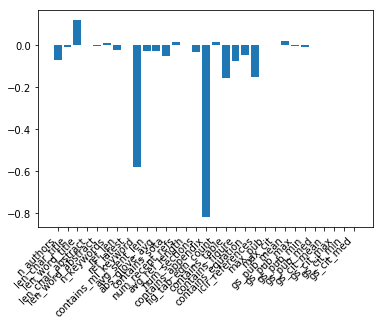

In [87]:
xax_labels = X.columns
xax = range(1, len(xax_labels)+1, 1)
yax = np.reshape(clf.coef_, (31,))

plt.bar(xax_labels, yax)
plt.xticks(rotation=45, ha="right")
# plt.xlabel(xax_labels)
plt.show()

## 3. L1 all features

In [83]:
model_results = pd.DataFrame()

X = data.drop(columns=['id','label'])
X_normalized = normalize(X)
y = data['label']
clf = LogisticRegression(penalty='l1').fit(X, y)
predictions = clf.predict(X)

results = cross_validate(clf, X, y, return_estimator=True)
results['estimator']
results.pop('estimator')
accuracy = np.mean(results['test_score'])
model_results = [accuracy, results]
# for idx, (prediction, label) in enumerate(zip(predictions, y)):
#     if prediction != label:
#         print(data.loc[idx,:], prediction, label)

In [84]:
model_results

[0.6207942636514066,
 {'fit_time': array([0.04215312, 0.04338002, 0.05139327]),
  'score_time': array([0.00216985, 0.00221682, 0.00097775]),
  'test_score': array([0.62162162, 0.60810811, 0.63265306])}]

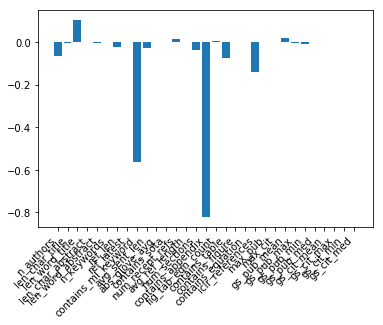

In [80]:
xax_labels = X.columns
xax = range(1, len(xax_labels)+1, 1)
yax = np.reshape(clf.coef_, (31,))

plt.bar(xax_labels, yax)
plt.xticks(rotation=45, ha="right")
# plt.xlabel(xax_labels)
plt.show()